# L5: Augmenting Data — LLM-Based Text Analysis

## Applied Example: Amazon Product Reviews

This notebook demonstrates three key technical skills for using Large Language Models (LLMs) as data augmentation tools:

1. **Calling LLMs Through an API** — Making structured requests to foundation models
2. **Structuring the Output** — Enforcing categorical constraints using JSON schemas
3. **Estimating the Cost** — Computing token usage and projecting inference budgets

### Learning Approach

**All code is ready to run.** Your task is to:
- Execute each cell in order
- Read the outputs carefully
- Answer the reflection prompts
- Experiment by re-running cells with small variations

---

## Section 0: Setup

We'll use **OpenRouter** to access GPT-4o-mini. OpenRouter provides a unified API for multiple LLM providers.

### Prerequisites
1. Get an API key from [OpenRouter](https://openrouter.ai/)
2. You'll be prompted to enter it securely below (it won't be displayed)

In [1]:
# Install required packages
import sys
!{sys.executable} -m pip install -q openai pandas numpy jsonschema tiktoken matplotlib seaborn python-dotenv tqdm scikit-learn

print("✓ Packages installed")

/Users/danielyue/Code/observational-studies-phd-course/l5-augmenting-data/.venv/bin/python: No module named pip
✓ Packages installed


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import json
import jsonschema
import tiktoken
import matplotlib.pyplot as plt
import seaborn as sns
from openai import OpenAI
import time
from typing import List, Dict
from tqdm.auto import tqdm
from dotenv import load_dotenv
import os

# Configure plotting
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("✓ Libraries imported")

✓ Libraries imported


In [7]:
# Load API key from .env file
# Note: For students without .env, uncomment the getpass line below
load_dotenv('../.env')
OPENROUTER_API_KEY = os.getenv('OPENROUTER_API_KEY')

# Alternative: Enter key manually (uncomment if .env doesn't exist)
# from getpass import getpass
# OPENROUTER_API_KEY = getpass("Enter your OpenRouter API key: ")

if not OPENROUTER_API_KEY:
    raise ValueError("OPENROUTER_API_KEY not found. Please set it in .env file or use getpass.")

# Initialize OpenAI client with OpenRouter endpoint
client = OpenAI(
    base_url="https://openrouter.ai/api/v1",
    api_key=OPENROUTER_API_KEY,
)

# Model configuration
MODEL = "google/gemini-2.5-flash-lite"#"openai/gpt-4o-mini"

# Initialize metrics tracking
metrics = {
    'section_times': {},
    'api_calls': 0,
    'total_input_tokens': 0,
    'total_output_tokens': 0,
    'total_cost': 0.0
}

print(f"✓ Client configured for model: {MODEL}")
print(f"✓ Metrics tracking initialized")

✓ Client configured for model: google/gemini-2.5-flash-lite
✓ Metrics tracking initialized


### Load Data

We're using a 100-row sample of Amazon product reviews. Each review has:
- **reviewText**: The review content
- **polarity**: Pre-labeled sentiment (0=Negative, 1=Positive)
- **warning_flag**: Rule-based label (1 if review contains "beware", "avoid", "return", "fake", or "warning")

The pre-existing `polarity` serves as a benchmark. We'll see how an LLM's classification compares.

In [4]:
# Load the 100-row dataset
df = pd.read_csv('data/processed/amazon_reviews_100.csv')

print(f"Dataset loaded: {len(df)} rows")
print(f"\nColumns: {list(df.columns)}")
print(f"\nFirst few rows:")
df.head()

Dataset loaded: 100 rows

Columns: ['reviewText', 'polarity', 'warning_flag']

First few rows:


,reviewText,polarity,warning_flag
0,Excellent value! Works exactly as described. F...,1,0
1,Broke after a week. False advertising. refund ...,0,1
2,Love it! Exceeded expectations. Will definitel...,1,0
3,Don't waste your money. Arrived damaged. Had t...,0,1
4,Love it! Fast delivery. Will definitely buy ag...,1,0


In [8]:
# Exploratory summary
print("="*60)
print("EXPLORATORY SUMMARY")
print("="*60)

# Polarity distribution
print("\n1. Polarity Distribution:")
polarity_counts = df['polarity'].value_counts().sort_index()
print(polarity_counts)
print(f"   Positive rate: {df['polarity'].mean()*100:.1f}%")

# Warning flag distribution
print("\n2. Warning Flag Distribution:")
warning_counts = df['warning_flag'].value_counts().sort_index()
print(warning_counts)
print(f"   Warning rate: {df['warning_flag'].mean()*100:.1f}%")

# Review length statistics
df['review_length'] = df['reviewText'].fillna('').str.len()
print("\n3. Review Length Statistics (characters):")
print(df['review_length'].describe())

# Show a couple example reviews
print("\n4. Sample Reviews:")
print("\n" + "-"*60)
print("Example 1 (Positive):")
pos_example = df[df['polarity'] == 1].iloc[0]
print(f"Text: {pos_example['reviewText'][:200]}...")
print(f"Warning flag: {pos_example['warning_flag']}")

print("\n" + "-"*60)
print("Example 2 (Negative):")
neg_example = df[df['polarity'] == 0].iloc[0]
print(f"Text: {neg_example['reviewText'][:200]}...")
print(f"Warning flag: {neg_example['warning_flag']}")

EXPLORATORY SUMMARY

1. Polarity Distribution:
polarity
0    50
1    50
Name: count, dtype: int64
   Positive rate: 50.0%

2. Warning Flag Distribution:
warning_flag
0    59
1    41
Name: count, dtype: int64
   Warning rate: 41.0%

3. Review Length Statistics (characters):
count    100.000000
mean      60.390000
std        6.732846
min       44.000000
25%       56.000000
50%       59.000000
75%       64.000000
max       86.000000
Name: review_length, dtype: float64

4. Sample Reviews:

------------------------------------------------------------
Example 1 (Positive):
Text: Excellent value! Works exactly as described. Fast delivery....
Warning flag: 0

------------------------------------------------------------
Example 2 (Negative):
Text: Broke after a week. False advertising. refund immediately....
Warning flag: 1


---

## Section 1: Calling LLMs Through an API

### Goal
Demonstrate a complete end-to-end API call for text classification.

### Key Concepts
- **Prompt engineering**: Explicit instructions constrain model behavior
- **Request payload**: Specify model, messages, temperature, max_tokens
- **Response parsing**: Extract the model's output from the API response

### Why This Matters
Even without formal schema enforcement, clear prompts reduce output variability. However, natural language instructions alone aren't bulletproof—models may still generate unexpected formats like "very positive" or "somewhat negative." We'll address this in Section 2.

In [9]:
def classify_sentiment_basic(review_text: str) -> str:
    """
    Classify a single review using a simple prompt.
    Returns the model's response as a string.
    """
    prompt = f"""Classify this Amazon review as either Positive or Negative. 
Respond only with one of those two words.

Review: {review_text}

Classification:"""

    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.0,  # Deterministic
        max_tokens=10     # We only need 1-2 tokens for "Positive" or "Negative"
    )

    # Track API usage
    metrics['api_calls'] += 1
    if hasattr(response, 'usage'):
        metrics['total_input_tokens'] += response.usage.prompt_tokens
        metrics['total_output_tokens'] += response.usage.completion_tokens
        
    return response.choices[0].message.content.strip()

# Test on a single review
section_start = time.time()
test_review = df.iloc[0]['reviewText']
print("Test Review:")
print(f"{test_review[:200]}...\n")

result = classify_sentiment_basic(test_review)
print(f"LLM Classification: {result}")
print(f"Original Polarity: {df.iloc[0]['polarity']} (0=Negative, 1=Positive)")
print(f"\n⏱️  Time: {time.time() - section_start:.2f}s | API calls: {metrics['api_calls']}")

Test Review:
Excellent value! Works exactly as described. Fast delivery....

LLM Classification: Positive
Original Polarity: 1 (0=Negative, 1=Positive)

⏱️  Time: 0.44s | API calls: 1


### Batch Classification

Now let's classify a small batch of 5 reviews and compare the results.

In [ ]:
# Select 5 diverse reviews
section_start = time.time()
sample_indices = [0, 10, 20, 30, 40]
sample_df = df.iloc[sample_indices].copy()

# Classify each review
llm_predictions = []

print("Classifying 5 reviews...\n")
for idx, row in tqdm(sample_df.iterrows(), total=len(sample_df), desc="Processing reviews"):
    review_text = row['reviewText']
    prediction = classify_sentiment_basic(review_text)
    llm_predictions.append(prediction)

    print(f"Review {idx}:")
    print(f"  Text: {review_text[:100]}...")
    print(f"  LLM: {prediction}")
    print(f"  Original: {row['polarity']} (0=Negative, 1=Positive)")
    print()

    # Rate limiting (be nice to the API)
    time.sleep(0.5)

sample_df['llm_sentiment'] = llm_predictions
metrics['section_times']['Section 1 - Batch'] = time.time() - section_start
print(f"✓ Batch classification complete")
print(f"⏱️  Time: {metrics['section_times']['Section 1 - Batch']:.2f}s | Total API calls: {metrics['api_calls']}")

### 🤔 Reflection Question

**Look at the outputs above:**
1. Did the model always respond with exactly "Positive" or "Negative"?
2. If not, what variations did you see?
3. How might this create problems when processing thousands of reviews?

---

**Key Insight:**

Even with explicit instructions ("Respond only with one of those two words"), models may occasionally produce variations like:
- "positive" (lowercase)
- "Negative." (with punctuation)
- "The review is Positive" (full sentence)

This is where **structured outputs** become essential. Let's formalize the constraint.

---

## Section 2: Structuring the Output (Enforcing Categories)

### Goal
Use JSON Schema to **enforce** valid categorical responses at the API level.

### Key Concepts
- **JSON Schema**: A specification language for JSON data
- **Enum constraints**: Restrict values to a predefined set
- **Schema validation**: Programmatically verify that responses conform to expectations

### Why This Matters
With schema enforcement:
- Invalid categories (e.g., "Neutral") trigger errors instead of silent failures
- Downstream processing (DataFrames, databases) can assume clean categorical data
- Reliability increases across large batch jobs

In [10]:
# Define strict JSON schema
SCHEMA = {
    "name": "review_analysis",
    "strict": True,
    "schema": {
        "type": "object",
        "properties": {
            "sentiment": {
                "type": "string",
                "enum": ["Positive", "Negative"],
                "description": "Overall sentiment of the review"
            },
            "warning_flag": {
                "type": "boolean",
                "description": "True if review contains warning language about product issues"
            },
            "mentioned_products": {
                "type": "array",
                "items": {"type": "string"},
                "description": "List of product names or types mentioned in the review"
            }
        },
        "required": ["sentiment", "warning_flag", "mentioned_products"],
        "additionalProperties": False
    }
}

print("Schema defined:")
print(json.dumps(SCHEMA, indent=2))

Schema defined:
{
  "name": "review_analysis",
  "strict": true,
  "schema": {
    "type": "object",
    "properties": {
      "sentiment": {
        "type": "string",
        "enum": [
          "Positive",
          "Negative"
        ],
        "description": "Overall sentiment of the review"
      },
      "warning_flag": {
        "type": "boolean",
        "description": "True if review contains warning language about product issues"
      },
      "mentioned_products": {
        "type": "array",
        "items": {
          "type": "string"
        },
        "description": "List of product names or types mentioned in the review"
      }
    },
    "required": [
      "sentiment",
      "warning_flag",
      "mentioned_products"
    ],
    "additionalProperties": false
  }
}


In [11]:
def classify_with_schema(review_text: str) -> Dict:
    """
    Classify a review using structured output with JSON schema enforcement.
    Returns a validated dictionary.
    """
    prompt = f"""Analyze this Amazon product review and extract:
1. Sentiment: Classify as Positive or Negative
2. Warning flag: Does the review contain warnings about product issues?
3. Mentioned products: List any specific products mentioned

Review: {review_text}"""

    response = client.chat.completions.create(
        model=MODEL,
        messages=[
            {"role": "user", "content": prompt}
        ],
        temperature=0.0,
        response_format={
            "type": "json_schema",
            "json_schema": SCHEMA
        }
    )

    # Track API usage
    metrics['api_calls'] += 1
    if hasattr(response, 'usage'):
        metrics['total_input_tokens'] += response.usage.prompt_tokens
        metrics['total_output_tokens'] += response.usage.completion_tokens

    # Parse JSON response
    result = json.loads(response.choices[0].message.content)

    # Validate against schema (redundant but good practice)
    jsonschema.validate(instance=result, schema=SCHEMA["schema"])

    return result

# Test on a single review
section_start = time.time()
test_review = df.iloc[5]['reviewText']
print("Test Review:")
print(f"{test_review[:200]}...\n")

result = classify_with_schema(test_review)
print("Structured Output:")
print(json.dumps(result, indent=2))

print(f"\nOriginal Polarity: {df.iloc[5]['polarity']} (0=Negative, 1=Positive)")
print(f"Original Warning Flag: {df.iloc[5]['warning_flag']}")
print(f"\n⏱️  Time: {time.time() - section_start:.2f}s | Total API calls: {metrics['api_calls']}")

Test Review:
Fantastic! Fast delivery. Worth every penny....

Structured Output:
{
  "sentiment": "Positive",
  "warning_flag": false,
  "mentioned_products": []
}

Original Polarity: 1 (0=Negative, 1=Positive)
Original Warning Flag: 0

⏱️  Time: 0.60s | Total API calls: 2


### Process All 100 Reviews with Structured Output

Now let's apply this to our full dataset. This will take a few minutes.

**Note:** We'll process in batches with progress updates and rate limiting.

In [12]:
# Initialize results storage
section_start = time.time()
results = []
errors = []

# Option to test with fewer reviews (set to None to process all)
# TEST_SAMPLE_SIZE = 10  # Uncomment to test with 10 reviews first
TEST_SAMPLE_SIZE = None  # Process all reviews

if TEST_SAMPLE_SIZE:
    df_to_process = df.head(TEST_SAMPLE_SIZE)
    print(f"⚠️  TEST MODE: Processing only {TEST_SAMPLE_SIZE} reviews for testing")
else:
    df_to_process = df
    
print(f"Processing {len(df_to_process)} reviews with structured output...\n")

# Use tqdm for progress bar
for idx, row in tqdm(df_to_process.iterrows(), total=len(df_to_process), desc="Analyzing reviews"):
    try:
        result = classify_with_schema(row['reviewText'])
        result['original_index'] = idx
        results.append(result)

        # Rate limiting (adjust based on your API tier)
        time.sleep(0.2)  # 5 requests per second

    except Exception as e:
        tqdm.write(f"  Error on review {idx}: {e}")
        errors.append({'index': idx, 'error': str(e)})

metrics['section_times']['Section 2 - Full Processing'] = time.time() - section_start

print(f"\n✓ Processing complete")
print(f"  Successful: {len(results)}")
print(f"  Errors: {len(errors)}")
print(f"⏱️  Time: {metrics['section_times']['Section 2 - Full Processing']:.2f}s")
print(f"📊 Total API calls: {metrics['api_calls']}")
print(f"📊 Tokens - Input: {metrics['total_input_tokens']:,} | Output: {metrics['total_output_tokens']:,}")

Processing 100 reviews with structured output...



Analyzing reviews:   0%|          | 0/100 [00:00<?, ?it/s]


✓ Processing complete
  Successful: 100
  Errors: 0
⏱️  Time: 76.77s
📊 Total API calls: 102
📊 Tokens - Input: 6,114 | Output: 2,857


In [13]:
# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Merge with original data
df_enriched = df.merge(
    results_df,
    left_index=True,
    right_on='original_index',
    how='left'
)

# Convert sentiment to binary for comparison
df_enriched['llm_sentiment_binary'] = (df_enriched['sentiment'] == 'Positive').astype(int)

print("Enriched dataset (first few rows):")
display(df_enriched[['reviewText', 'polarity', 'sentiment', 'warning_flag_x', 'warning_flag_y', 'mentioned_products']].head(10))

print("\nColumn mapping:")
print("  warning_flag_x = original rule-based flag")
print("  warning_flag_y = LLM-generated flag")

Enriched dataset (first few rows):


,reviewText,polarity,sentiment,warning_flag_x,warning_flag_y,mentioned_products
0,Excellent value! Works exactly as described. F...,1,Positive,0,False,[]
1,Broke after a week. False advertising. refund ...,0,Negative,1,True,[]
2,Love it! Exceeded expectations. Will definitel...,1,Positive,0,False,[]
3,Don't waste your money. Arrived damaged. Had t...,0,Negative,1,True,[]
4,Love it! Fast delivery. Will definitely buy ag...,1,Positive,0,False,[]
5,Fantastic! Fast delivery. Worth every penny.,1,Positive,0,False,[]
6,Terrible quality. False advertising. Not happy...,0,Negative,0,True,[this product]
7,Exactly what I needed. Fast delivery. Fast shi...,1,Positive,0,False,[]
8,This product is great! Very durable. Highly re...,1,Positive,0,False,[]
9,Don't waste your money. Very poor construction...,0,Negative,1,True,[]



Column mapping:
  warning_flag_x = original rule-based flag
  warning_flag_y = LLM-generated flag


### Schema Enforcement: What Happens with Invalid Values?

Let's demonstrate what happens if we try to use an invalid sentiment value.

In [ ]:
# Create a schema that allows an invalid enum value (for demonstration)
INVALID_SCHEMA = {
    "type": "object",
    "properties": {
        "sentiment": {
            "type": "string",
            "enum": ["Positive", "Negative"]  # Only these two values allowed
        }
    },
    "required": ["sentiment"]
}

# Try to validate an invalid response
invalid_response = {"sentiment": "Neutral"}  # Not in enum!

try:
    jsonschema.validate(instance=invalid_response, schema=INVALID_SCHEMA)
    print("✓ Validation passed")
except jsonschema.exceptions.ValidationError as e:
    print("✗ Validation failed (as expected):")
    print(f"  Error: {e.message}")
    print(f"\nThis is exactly what we want! The schema prevents invalid categories.")

### 🤔 Reflection Questions

1. **Compare the structured vs. unstructured outputs:**
   - Which approach gives you more confidence for large-scale processing?
   - What additional information did the structured approach provide?

2. **Schema design trade-offs:**
   - What if you wanted to capture "Mixed" sentiment? How would you modify the schema?
   - What's the cost of adding more fields (e.g., "confidence_score", "key_phrases")?

3. **Error handling:**
   - If schema validation fails, should you retry, skip, or flag for manual review?

---

## Section 3: Estimating the Cost

### Goal
Calculate the actual cost of LLM inference and project to larger datasets.

### Key Concepts
- **Tokenization**: How text is converted to model inputs
- **Token counting**: Measuring both input (prompt) and output (completion) tokens
- **Pricing models**: Cost per 1K tokens varies by model and provider

### Why This Matters
LLM costs scale linearly with:
- Number of reviews
- Length of reviews
- Complexity of schema (more fields = more output tokens)
- Model choice (GPT-4 vs GPT-3.5 vs open-source)

For research budgets, understanding cost early prevents mid-project surprises.

In [14]:
# Initialize tokenizer for GPT-4o-mini (uses same encoding as GPT-4)
tokenizer = tiktoken.encoding_for_model("gpt-4o-mini")

# OpenAI GPT-4o-mini pricing (as of 2024)
INPUT_COST_PER_1K = 0.00015   # $0.15 per 1M input tokens
OUTPUT_COST_PER_1K = 0.0006   # $0.60 per 1M output tokens

print(f"Pricing for {MODEL}:")
print(f"  Input:  ${INPUT_COST_PER_1K:.5f} per 1K tokens")
print(f"  Output: ${OUTPUT_COST_PER_1K:.5f} per 1K tokens")

Pricing for google/gemini-2.5-flash-lite:
  Input:  $0.00015 per 1K tokens
  Output: $0.00060 per 1K tokens


In [15]:
def count_tokens(text: str) -> int:
    """Count tokens in a text string."""
    return len(tokenizer.encode(text))

def estimate_cost(input_tokens: int, output_tokens: int) -> float:
    """Calculate cost given token counts."""
    input_cost = (input_tokens / 1000) * INPUT_COST_PER_1K
    output_cost = (output_tokens / 1000) * OUTPUT_COST_PER_1K
    return input_cost + output_cost

# Analyze token usage for our 100 reviews
token_stats = []

for idx, row in df_enriched.iterrows():
    # Reconstruct the prompt (approximately)
    prompt = f"""Analyze this Amazon product review and extract:
1. Sentiment: Classify as Positive or Negative
2. Warning flag: Does the review contain warnings about product issues?
3. Mentioned products: List any specific products mentioned

Review: {row['reviewText']}"""

    # Count input tokens
    input_tokens = count_tokens(prompt)

    # Estimate output tokens from the actual JSON response
    if pd.notna(row['sentiment']):
        output_json = json.dumps({
            'sentiment': row['sentiment'],
            'warning_flag': bool(row['warning_flag_y']),
            'mentioned_products': row['mentioned_products']
        })
        output_tokens = count_tokens(output_json)
    else:
        output_tokens = 0

    token_stats.append({
        'input_tokens': input_tokens,
        'output_tokens': output_tokens,
        'total_tokens': input_tokens + output_tokens,
        'cost': estimate_cost(input_tokens, output_tokens)
    })

token_df = pd.DataFrame(token_stats)

print("Token Usage Statistics:")
print(token_df.describe())

Token Usage Statistics:
       input_tokens  output_tokens  total_tokens          cost
count    100.000000     100.000000     100.00000  1.000000e+02
mean      60.220000      19.160000      79.38000  2.052900e-05
std        1.322532       0.598314       1.57493  4.492519e-07
min       57.000000      19.000000      76.00000  1.995000e-05
25%       59.000000      19.000000      78.00000  2.025000e-05
50%       60.000000      19.000000      79.00000  2.040000e-05
75%       61.000000      19.000000      80.00000  2.055000e-05
max       63.000000      22.000000      83.00000  2.235000e-05


In [16]:
# Calculate total cost using actual API-reported tokens
INPUT_COST_PER_1K = 0.00015   # $0.15 per 1M input tokens
OUTPUT_COST_PER_1K = 0.0006   # $0.60 per 1M output tokens

# Calculate actual costs from tracked metrics
actual_input_cost = (metrics['total_input_tokens'] / 1000) * INPUT_COST_PER_1K
actual_output_cost = (metrics['total_output_tokens'] / 1000) * OUTPUT_COST_PER_1K
actual_total_cost = actual_input_cost + actual_output_cost

print("="*60)
print("ACTUAL COST ANALYSIS (from API usage)")
print("="*60)
print(f"\nTotal input tokens:  {metrics['total_input_tokens']:,}")
print(f"Total output tokens: {metrics['total_output_tokens']:,}")
print(f"Total tokens:        {metrics['total_input_tokens'] + metrics['total_output_tokens']:,}")
print(f"\nInput cost:          ${actual_input_cost:.6f}")
print(f"Output cost:         ${actual_output_cost:.6f}")
print(f"Total cost:          ${actual_total_cost:.4f}")
print(f"Cost per review:     ${actual_total_cost/len(df):.6f}")

# Store in metrics
metrics['total_cost'] = actual_total_cost

# Extrapolate to larger datasets
print("\n" + "-"*60)
print("EXTRAPOLATION TO LARGER DATASETS")
print("-"*60)

avg_cost_per_review = actual_total_cost / len(df)

dataset_sizes = [1_000, 10_000, 100_000, 1_000_000]
for size in dataset_sizes:
    projected_cost = avg_cost_per_review * size
    print(f"{size:>10,} reviews: ${projected_cost:>10.2f}")

print("\n" + "="*60)

ACTUAL COST ANALYSIS (from API usage)

Total input tokens:  6,114
Total output tokens: 2,857
Total tokens:        8,971

Input cost:          $0.000917
Output cost:         $0.001714
Total cost:          $0.0026
Cost per review:     $0.000026

------------------------------------------------------------
EXTRAPOLATION TO LARGER DATASETS
------------------------------------------------------------
     1,000 reviews: $      0.03
    10,000 reviews: $      0.26
   100,000 reviews: $      2.63
 1,000,000 reviews: $     26.31



### Cost Breakdown by Component

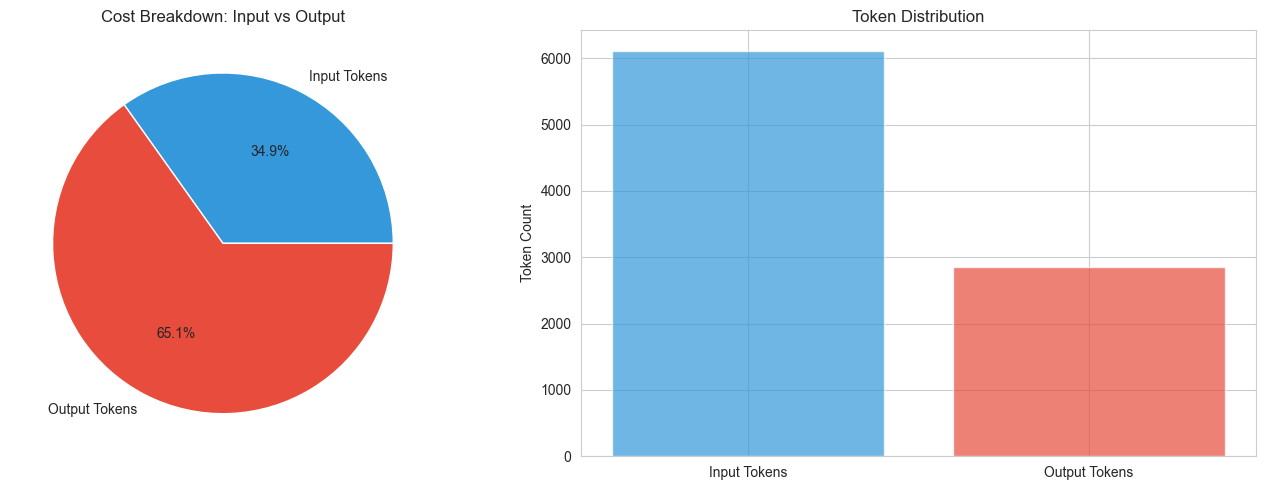

Key Insights:
  - Output tokens cost 4.0x more than input tokens
  - Average input tokens per review: 61.1
  - Average output tokens per review: 28.6
  - Output represents 65.1% of total cost
  - Total API calls made: 102

⏱️  Section timings:
    Section 2 - Full Processing: 76.77s


In [17]:
# Calculate component costs from actual usage
input_cost = (metrics['total_input_tokens'] / 1000) * INPUT_COST_PER_1K
output_cost = (metrics['total_output_tokens'] / 1000) * OUTPUT_COST_PER_1K

# Visualize cost breakdown
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart: Input vs Output cost
axes[0].pie(
    [input_cost, output_cost],
    labels=['Input Tokens', 'Output Tokens'],
    autopct='%1.1f%%',
    colors=['#3498db', '#e74c3c']
)
axes[0].set_title('Cost Breakdown: Input vs Output')

# Bar chart: Token distribution
token_data = pd.DataFrame({
    'Category': ['Input Tokens', 'Output Tokens'],
    'Count': [metrics['total_input_tokens'], metrics['total_output_tokens']]
})
axes[1].bar(token_data['Category'], token_data['Count'], color=['#3498db', '#e74c3c'], alpha=0.7)
axes[1].set_ylabel('Token Count')
axes[1].set_title('Token Distribution')
axes[1].ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.show()

print("Key Insights:")
print(f"  - Output tokens cost {OUTPUT_COST_PER_1K/INPUT_COST_PER_1K:.1f}x more than input tokens")
print(f"  - Average input tokens per review: {metrics['total_input_tokens']/len(df):.1f}")
print(f"  - Average output tokens per review: {metrics['total_output_tokens']/len(df):.1f}")
print(f"  - Output represents {output_cost/(input_cost+output_cost)*100:.1f}% of total cost")
print(f"  - Total API calls made: {metrics['api_calls']}")
print(f"\n⏱️  Section timings:")
for section, duration in metrics['section_times'].items():
    print(f"    {section}: {duration:.2f}s")

### 🤔 Reflection Questions

1. **Budget constraints:**
   - At what dataset size does cost become a limiting factor for your research?
   - What if you switched to a cheaper model like GPT-3.5-turbo (60% cheaper)?

2. **Schema complexity:**
   - Our schema extracts 3 fields. What if you added 5 more (e.g., key_phrases, confidence_score, product_category)?
   - How would this affect output tokens and cost?

3. **Alternative approaches:**
   - Could you use a smaller model for simple sentiment, reserving expensive models for complex analysis?
   - What about fine-tuning an open-source model (upfront cost vs. per-inference savings)?

---

## Section 4: Quick Visualization

Let's compare the LLM-based labels with our baseline (rule-based and original polarity).

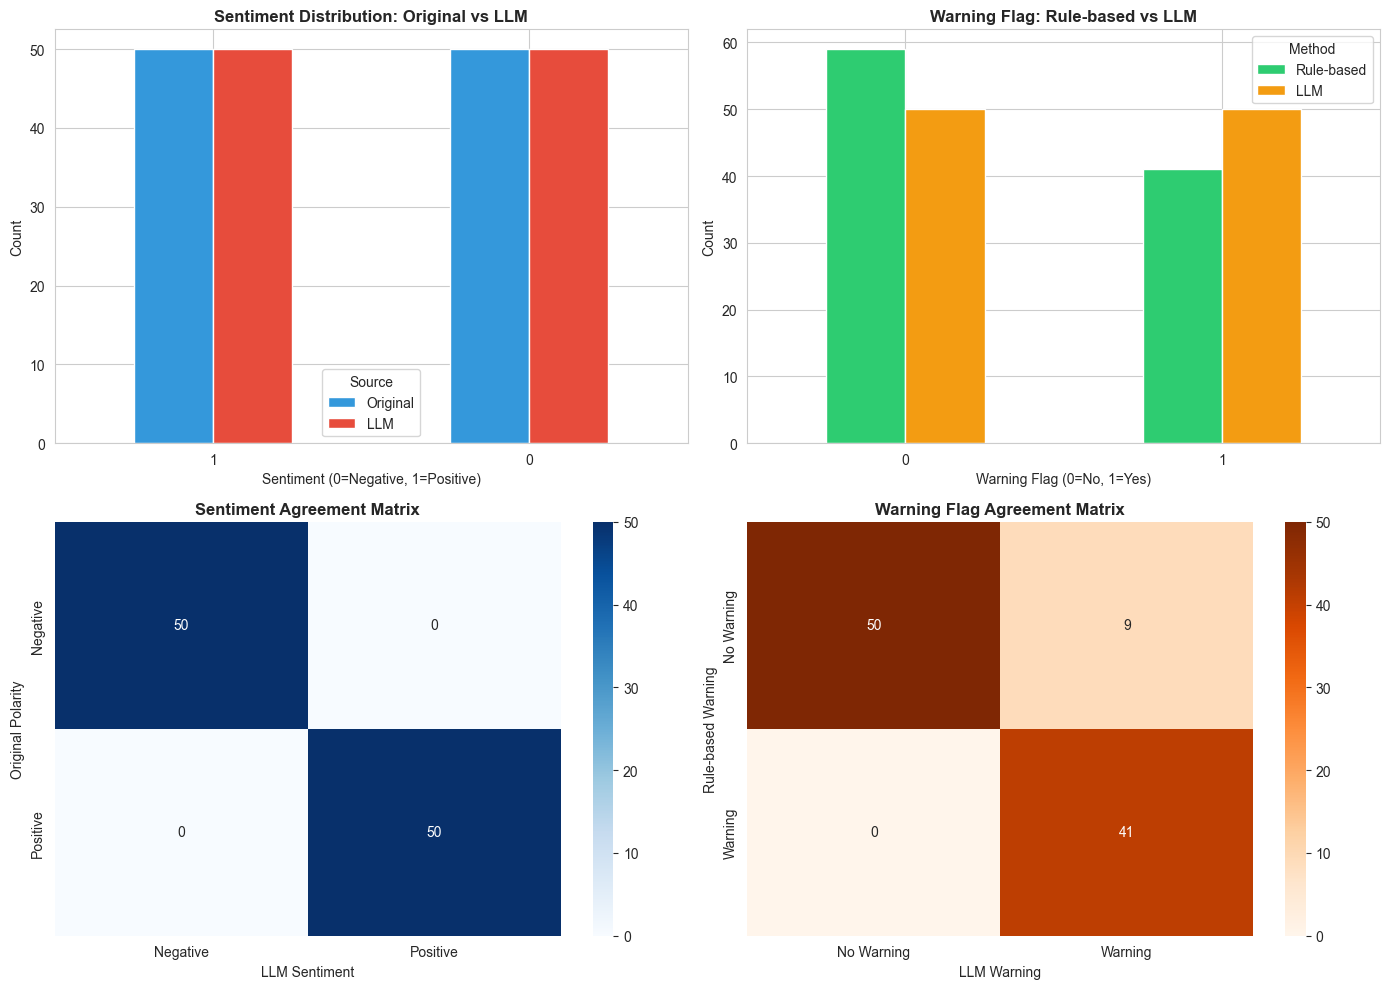

In [18]:
# Prepare comparison data
comparison_data = pd.DataFrame({
    'Original Polarity': df_enriched['polarity'],
    'LLM Sentiment': df_enriched['llm_sentiment_binary'],
    'Rule-based Warning': df_enriched['warning_flag_x'],
    'LLM Warning': df_enriched['warning_flag_y']
})

# Create comparison visualizations
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Sentiment comparison
sentiment_comparison = pd.DataFrame({
    'Original': comparison_data['Original Polarity'].value_counts(),
    'LLM': comparison_data['LLM Sentiment'].value_counts()
})
sentiment_comparison.plot(kind='bar', ax=axes[0, 0], color=['#3498db', '#e74c3c'])
axes[0, 0].set_title('Sentiment Distribution: Original vs LLM', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Sentiment (0=Negative, 1=Positive)')
axes[0, 0].set_ylabel('Count')
axes[0, 0].legend(title='Source')
axes[0, 0].tick_params(axis='x', rotation=0)

# 2. Warning flag comparison
warning_comparison = pd.DataFrame({
    'Rule-based': comparison_data['Rule-based Warning'].value_counts(),
    'LLM': comparison_data['LLM Warning'].value_counts()
})
warning_comparison.plot(kind='bar', ax=axes[0, 1], color=['#2ecc71', '#f39c12'])
axes[0, 1].set_title('Warning Flag: Rule-based vs LLM', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Warning Flag (0=No, 1=Yes)')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend(title='Method')
axes[0, 1].tick_params(axis='x', rotation=0)

# 3. Agreement matrix for sentiment
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm_sentiment = confusion_matrix(comparison_data['Original Polarity'], comparison_data['LLM Sentiment'])
sns.heatmap(cm_sentiment, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0],
            xticklabels=['Negative', 'Positive'],
            yticklabels=['Negative', 'Positive'])
axes[1, 0].set_title('Sentiment Agreement Matrix', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Original Polarity')
axes[1, 0].set_xlabel('LLM Sentiment')

# 4. Agreement matrix for warning flag
cm_warning = confusion_matrix(comparison_data['Rule-based Warning'], comparison_data['LLM Warning'])
sns.heatmap(cm_warning, annot=True, fmt='d', cmap='Oranges', ax=axes[1, 1],
            xticklabels=['No Warning', 'Warning'],
            yticklabels=['No Warning', 'Warning'])
axes[1, 1].set_title('Warning Flag Agreement Matrix', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Rule-based Warning')
axes[1, 1].set_xlabel('LLM Warning')

plt.tight_layout()
plt.show()

In [19]:
# Calculate agreement metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print("="*60)
print("AGREEMENT METRICS")
print("="*60)

# Sentiment metrics
print("\n1. Sentiment Classification (LLM vs Original Polarity):")
sentiment_accuracy = accuracy_score(comparison_data['Original Polarity'], comparison_data['LLM Sentiment'])
sentiment_precision = precision_score(comparison_data['Original Polarity'], comparison_data['LLM Sentiment'])
sentiment_recall = recall_score(comparison_data['Original Polarity'], comparison_data['LLM Sentiment'])
sentiment_f1 = f1_score(comparison_data['Original Polarity'], comparison_data['LLM Sentiment'])

print(f"   Accuracy:  {sentiment_accuracy:.3f}")
print(f"   Precision: {sentiment_precision:.3f}")
print(f"   Recall:    {sentiment_recall:.3f}")
print(f"   F1 Score:  {sentiment_f1:.3f}")

# Warning flag metrics
print("\n2. Warning Flag Detection (LLM vs Rule-based):")
warning_accuracy = accuracy_score(comparison_data['Rule-based Warning'], comparison_data['LLM Warning'])
warning_precision = precision_score(comparison_data['Rule-based Warning'], comparison_data['LLM Warning'], zero_division=0)
warning_recall = recall_score(comparison_data['Rule-based Warning'], comparison_data['LLM Warning'], zero_division=0)
warning_f1 = f1_score(comparison_data['Rule-based Warning'], comparison_data['LLM Warning'], zero_division=0)

print(f"   Accuracy:  {warning_accuracy:.3f}")
print(f"   Precision: {warning_precision:.3f}")
print(f"   Recall:    {warning_recall:.3f}")
print(f"   F1 Score:  {warning_f1:.3f}")

print("\n" + "="*60)

AGREEMENT METRICS

1. Sentiment Classification (LLM vs Original Polarity):
   Accuracy:  1.000
   Precision: 1.000
   Recall:    1.000
   F1 Score:  1.000

2. Warning Flag Detection (LLM vs Rule-based):
   Accuracy:  0.910
   Precision: 0.820
   Recall:    1.000
   F1 Score:  0.901



### Investigate Disagreements

Let's look at cases where the LLM and original labels disagree.

In [20]:
# Find disagreements in sentiment
sentiment_disagreements = df_enriched[
    df_enriched['polarity'] != df_enriched['llm_sentiment_binary']
].copy()

print(f"Found {len(sentiment_disagreements)} sentiment disagreements ({len(sentiment_disagreements)/len(df)*100:.1f}%)\n")

if len(sentiment_disagreements) > 0:
    print("Sample disagreements:")
    print("="*60)

    for i, row in sentiment_disagreements.head(3).iterrows():
        print(f"\nReview {i}:")
        print(f"Text: {row['reviewText'][:200]}...")
        print(f"Original: {'Positive' if row['polarity'] == 1 else 'Negative'}")
        print(f"LLM: {row['sentiment']}")
        print("-"*60)
else:
    print("Perfect agreement on sentiment!")

Found 0 sentiment disagreements (0.0%)

Perfect agreement on sentiment!


In [21]:
# Find disagreements in warning flags
warning_disagreements = df_enriched[
    df_enriched['warning_flag_x'] != df_enriched['warning_flag_y']
].copy()

print(f"Found {len(warning_disagreements)} warning flag disagreements ({len(warning_disagreements)/len(df)*100:.1f}%)\n")

if len(warning_disagreements) > 0:
    print("Sample disagreements:")
    print("="*60)

    for i, row in warning_disagreements.head(3).iterrows():
        print(f"\nReview {i}:")
        print(f"Text: {row['reviewText'][:200]}...")
        print(f"Rule-based: {bool(row['warning_flag_x'])}")
        print(f"LLM: {bool(row['warning_flag_y'])}")
        print("-"*60)
else:
    print("Perfect agreement on warning flags!")

Found 9 warning flag disagreements (9.0%)

Sample disagreements:

Review 6:
Text: Terrible quality. False advertising. Not happy with this product!...
Rule-based: False
LLM: True
------------------------------------------------------------

Review 13:
Text: Terrible item. Doesn't work as advertised. Not happy with this product!...
Rule-based: False
LLM: True
------------------------------------------------------------

Review 34:
Text: The quality is disappointing. Stopped working quickly. I would refund it....
Rule-based: False
LLM: True
------------------------------------------------------------


### Additional LLM Features: Mentioned Products

One advantage of LLM-based analysis is extracting structured information that wasn't in the original data.

Total products mentioned: 7
Unique products: 4

Top 10 mentioned products:
this product    2
tool            2
device          2
product         1
Name: count, dtype: int64


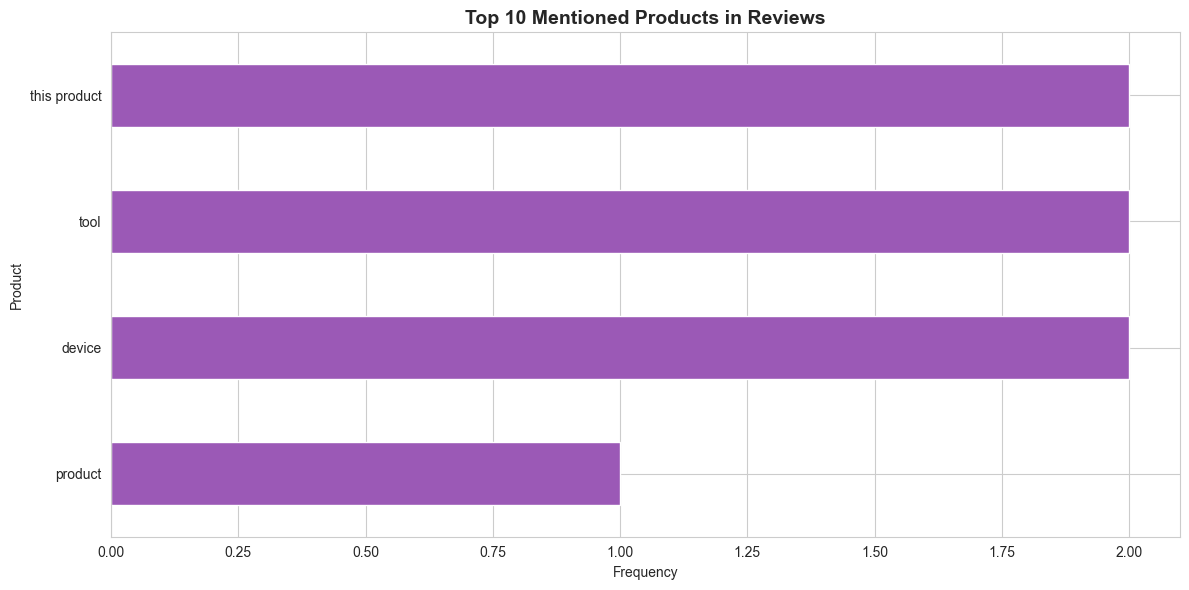

In [22]:
# Analyze mentioned products
# Note: mentioned_products is a list stored as a string in the DataFrame
import ast

all_products = []
for products in df_enriched['mentioned_products'].dropna():
    try:
        if isinstance(products, str):
            product_list = ast.literal_eval(products)
        else:
            product_list = products

        if isinstance(product_list, list):
            all_products.extend(product_list)
    except:
        pass

print(f"Total products mentioned: {len(all_products)}")
print(f"Unique products: {len(set(all_products))}\n")

if all_products:
    # Count frequency
    product_counts = pd.Series(all_products).value_counts().head(10)

    print("Top 10 mentioned products:")
    print(product_counts)

    # Visualize
    plt.figure(figsize=(12, 6))
    product_counts.plot(kind='barh', color='#9b59b6')
    plt.xlabel('Frequency')
    plt.ylabel('Product')
    plt.title('Top 10 Mentioned Products in Reviews', fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("No products were explicitly extracted by the LLM.")

### 🤔 Reflection Questions

1. **Where did LLM and baseline labels diverge most?**
   - Look at the disagreement examples above
   - Which labeling method seems more accurate? Why?

2. **Warning flag comparison:**
   - The rule-based method uses exact keyword matching
   - The LLM interprets semantic meaning
   - Which approach better captures "warnings" in natural language?

3. **Value of extracted products:**
   - Could you use this information for downstream analysis?
   - What other structured data might be useful to extract?

---

## Section 5: Reflection and Wrap-Up

### Summary of Key Skills

In this notebook, you learned:

1. **Calling LLMs Through an API**
   - Constructing prompts for classification tasks
   - Managing API requests (rate limiting, error handling)
   - Parsing and validating responses

2. **Structuring the Output**
   - Defining JSON schemas with enumerated categories
   - Enforcing constraints at the API level
   - Validating responses programmatically

3. **Estimating the Cost**
   - Counting tokens with tiktoken
   - Calculating per-request and total costs
   - Extrapolating to larger datasets

### Key Takeaways

✓ **Schema enforcement reduces ambiguity**  
Without enum constraints, models may generate unexpected categories. Structured outputs ensure reliability at scale.

✓ **LLMs capture semantic nuance**  
Keyword-based rules miss context. LLMs understand sentiment even when specific trigger words aren't present.

✓ **Cost scales linearly**  
Token usage determines your budget. Understanding cost early informs design choices (model selection, schema complexity, dataset size).

✓ **Trade-offs are everywhere**  
Cheaper models may be less accurate. Simpler schemas save money but lose information. Open-source models require infrastructure.

---

### 🎯 Final Reflection Questions

1. **Schema design:**
   - What value did schema enforcement add to this workflow?
   - What would you change about the schema if you were analyzing product reviews for a real research project?

2. **Label quality:**
   - Where did LLM and keyword-based labels diverge most?
   - Which approach do you trust more? Why?
   - How would you validate LLM labels without ground truth?

3. **Cost and scalability:**
   - At what dataset size does cost become a limiting factor for your research?
   - What strategies could reduce costs? (Hint: sampling, cheaper models, batch processing)

4. **Broader applications:**
   - What other text classification tasks could benefit from this approach?
   - When would you choose LLMs over traditional ML (e.g., fine-tuned BERT)?
   - What are the ethical considerations of using LLMs for automated labeling?

---

### 🚀 Suggested Experiments

Try modifying the notebook to explore different scenarios:

1. **Change the prompt:**
   - Add a "Neutral" category to the sentiment enum
   - Ask the LLM to explain its reasoning (add a "justification" field)

2. **Modify the schema:**
   - Add a "confidence_score" field (type: number, range 0-1)
   - Extract "key_phrases" that influenced the classification

3. **Compare models:**
   - Try GPT-3.5-turbo (cheaper but less capable)
   - Compare costs and accuracy

4. **Sample vs. full dataset:**
   - How do results on 100 reviews generalize to 1,000?
   - Is there a "saturation point" where more data doesn't change conclusions?

5. **Error analysis:**
   - Manually review 10 disagreements
   - Identify patterns in LLM failures
   - Propose prompt improvements

---

### 📚 Further Reading

- [OpenAI API Documentation](https://platform.openai.com/docs/)
- [JSON Schema Specification](https://json-schema.org/)
- [Prompt Engineering Guide](https://www.promptingguide.ai/)
- [Cost Optimization Strategies for LLMs](https://openai.com/pricing)

---

### ✅ You've completed L5: Augmenting Data!

You now have hands-on experience with:
- Calling LLM APIs for text analysis
- Enforcing structured outputs with JSON schemas
- Estimating and projecting inference costs

These skills are foundational for using LLMs as research tools in observational studies and beyond.
